In [71]:
%tensorflow_version 2.x
import os
import numpy as np
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow import keras
import pandas as pd
import seaborn as sn
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
import time
import math

%matplotlib inline

sn.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

Found GPU at: /device:GPU:0


In [25]:
csv_path = "https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410912000&period2=1626048000&interval=1d&events=history&includeAdjustedClose=true"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [26]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [27]:
df = df.sort_values('Date')

In [28]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [29]:
df.shape

(2491, 7)

Text(0, 0.5, 'Close Price (USD)')

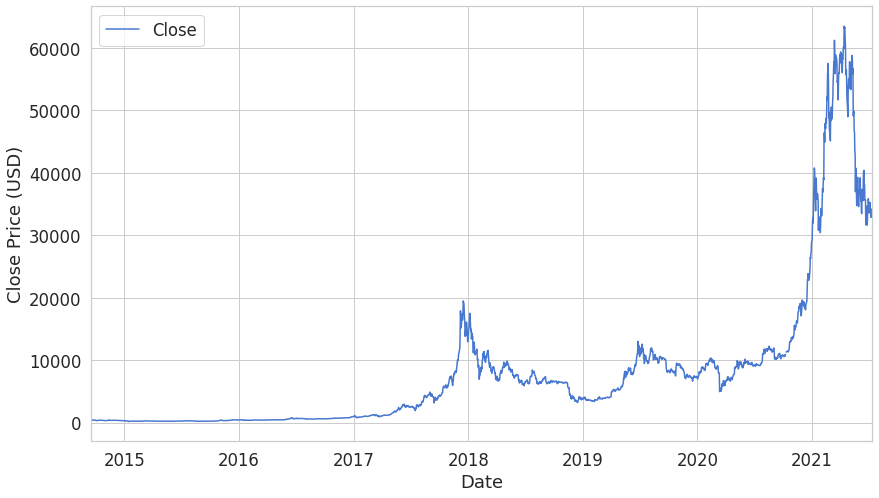

In [30]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

Text(0, 0.5, 'Close Price (USD)')

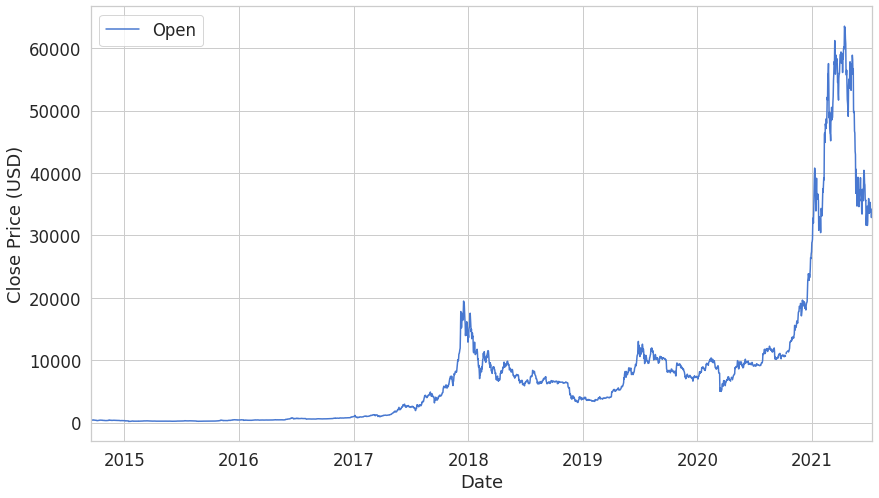

In [31]:
ax = df.plot(x='Date', y='Open');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Data processing

In [32]:
colnames = {
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Adj Close': 'adjClose',
    'Volume': 'volume'
}
df.rename(columns = colnames, inplace=True)
df.head()

,date,open,high,low,close,adjClose,volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


# Feature construction

In [33]:
df['dayVariation'] = df.apply(lambda row: row.close - row.open, axis=1)
df.head()

,date,open,high,low,close,adjClose,volume,dayVariation
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,-8.529999
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,-32.419983
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,-29.307007
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,14.230988
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,-9.263977


In [34]:
df['upDown'] = df.apply(lambda row: row.dayVariation / abs(row.dayVariation), axis=1)
df.head()

,date,open,high,low,close,adjClose,volume,dayVariation,upDown
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,-8.529999,-1.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,-32.419983,-1.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,-29.307007,-1.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,14.230988,1.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,-9.263977,-1.0


In [35]:
df.isna().sum()

date            0
open            4
high            4
low             4
close           4
adjClose        4
volume          4
dayVariation    4
upDown          4
dtype: int64

In [36]:
df[df['open'].isnull()]


,date,open,high,low,close,adjClose,volume,dayVariation,upDown
2039,2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2214,2020-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2217,2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2218,2020-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df.dropna(inplace=True)

In [38]:
df.isna().sum()

date            0
open            0
high            0
low             0
close           0
adjClose        0
volume          0
dayVariation    0
upDown          0
dtype: int64

# Data analysis

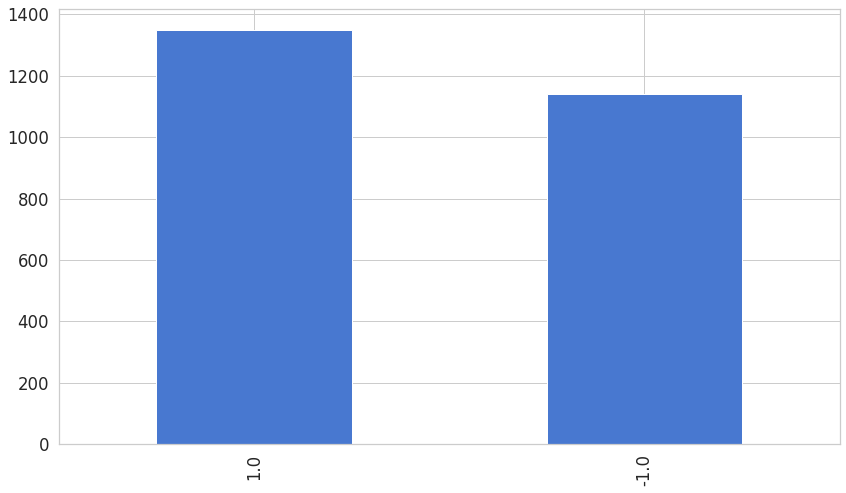

In [39]:
df['upDown'].value_counts().plot(kind='bar')

# Close model

## Normalization

In [40]:
close_scaler = MinMaxScaler()

close = df.close.values.reshape(-1, 1)

scaled_close = close_scaler.fit_transform(close)

In [41]:
scaled_close

array([[0.00440947],
       [0.00389002],
       [0.0034219 ],
       ...,
       [0.52652554],
       [0.53789016],
       [0.52076684]])

In [42]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_close_train, y_close_train, X_close_test, y_close_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [43]:
X_close_train.shape

(2267, 99, 1)

In [44]:
X_close_test.shape

(120, 99, 1)

## Model

In [45]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model_close = keras.Sequential()

model_close.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_close_train.shape[-1])))
model_close.add(Dropout(rate=DROPOUT))

model_close.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model_close.add(Dropout(rate=DROPOUT))

model_close.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model_close.add(Dense(units=1))

model_close.add(Activation('linear'))

## Training

In [46]:
model_close.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [47]:
BATCH_SIZE = 64

start = time.time()
history_close = model_close.fit(
    X_close_train, 
    y_close_train, 
    epochs=15, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

training_time = int(math.floor(time.time() - start))
print('Training time(s):', training_time)

Epoch 1/15
32/32 [==============================] - 12s 77ms/step - loss: 0.0031 - val_loss: 0.0741
Epoch 2/15
32/32 [==============================] - 1s 45ms/step - loss: 0.0039 - val_loss: 0.0787
Epoch 3/15
32/32 [==============================] - 1s 45ms/step - loss: 0.0025 - val_loss: 0.0581
Epoch 4/15
32/32 [==============================] - 1s 46ms/step - loss: 0.0030 - val_loss: 0.0368
Epoch 5/15
32/32 [==============================] - 1s 45ms/step - loss: 0.0016 - val_loss: 0.0169
Epoch 6/15
32/32 [==============================] - 1s 45ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 7/15
32/32 [==============================] - 1s 45ms/step - loss: 0.0013 - val_loss: 0.0072
Epoch 8/15
32/32 [==============================] - 1s 45ms/step - loss: 0.0010 - val_loss: 0.0251
Epoch 9/15
32/32 [==============================] - 1s 45ms/step - loss: 8.1993e-04 - val_loss: 0.0051
Epoch 10/15
32/32 [==============================] - 1s 45ms/step - loss: 0.0018 - val_loss: 0.0071
Epoc

## Evaluation

In [48]:
model_close.evaluate(X_close_test, y_close_test)

4/4 [==============================] - 0s 36ms/step - loss: 0.0796


0.0796213448047638

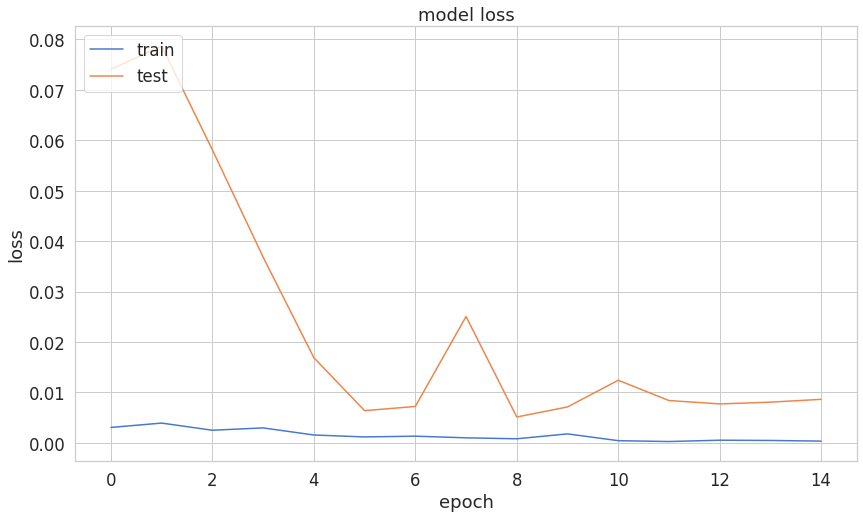

In [50]:
plt.plot(history_close.history['loss'])
plt.plot(history_close.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

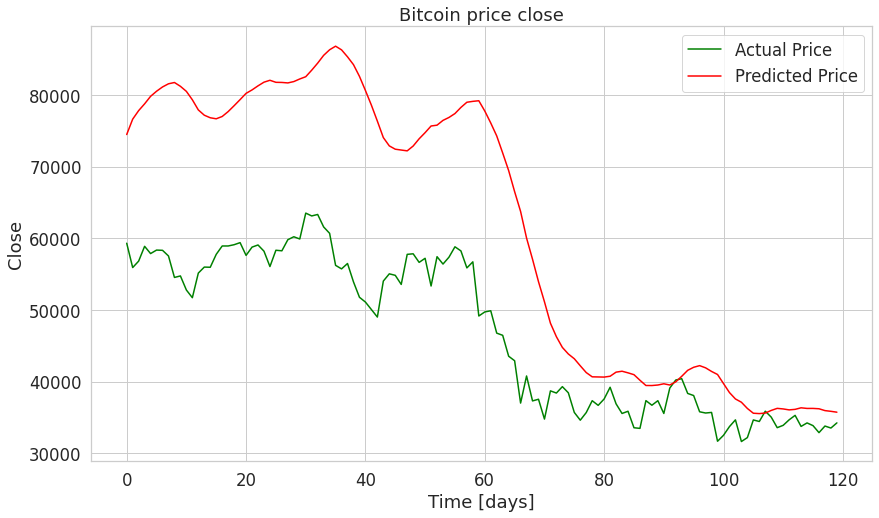

In [52]:
y_close_predict = model_close.predict(X_close_test)

y_close_test_inverse = close_scaler.inverse_transform(y_close_test)
y_close_predict_inverse = close_scaler.inverse_transform(y_close_predict)
 
plt.plot(y_close_test_inverse, label="Actual Price", color='green')
plt.plot(y_close_predict_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price close')
plt.xlabel('Time [days]')
plt.ylabel('Close')
plt.legend(loc='best')
 
plt.show();

# Open model


## Normalization

In [53]:
open_scaler = MinMaxScaler()

open = df.open.values.reshape(-1, 1)

scaled_open = open_scaler.fit_transform(open)

In [54]:
scaled_open.shape

(2487, 1)

## Split

In [55]:
X_open_train, y_open_train, X_open_test, y_open_test = preprocess(scaled_open, SEQ_LEN, train_split = 0.95)

In [56]:
X_open_train.shape

(2267, 99, 1)

In [57]:
X_open_test.shape

(120, 99, 1)

## Model

In [58]:
DROPOUT_OPEN = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model_open = keras.Sequential()

model_open.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_open_train.shape[-1])))
model_open.add(Dropout(rate=DROPOUT_OPEN))

model_open.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model_open.add(Dropout(rate=DROPOUT_OPEN))

model_open.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model_open.add(Dense(units=1))

model_open.add(Activation('linear'))

## Training

In [59]:
model_open.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [60]:
BATCH_SIZE = 10

start = time.time()
history_open = model_open.fit(
    X_open_train, 
    y_open_train, 
    epochs=15, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

training_time = int(math.floor(time.time() - start))
print('Training time(s):', training_time)

Epoch 1/15
204/204 [==============================] - 9s 30ms/step - loss: 6.1728e-04 - val_loss: 0.0795
Epoch 2/15
204/204 [==============================] - 5s 26ms/step - loss: 0.0012 - val_loss: 0.0940
Epoch 3/15
204/204 [==============================] - 5s 27ms/step - loss: 0.0011 - val_loss: 0.0923
Epoch 4/15
204/204 [==============================] - 5s 27ms/step - loss: 0.0013 - val_loss: 0.0916
Epoch 5/15
204/204 [==============================] - 5s 27ms/step - loss: 0.0015 - val_loss: 0.0930
Epoch 6/15
204/204 [==============================] - 5s 26ms/step - loss: 0.0016 - val_loss: 0.0887
Epoch 7/15
204/204 [==============================] - 5s 26ms/step - loss: 0.0016 - val_loss: 0.0839
Epoch 8/15
204/204 [==============================] - 5s 26ms/step - loss: 0.0014 - val_loss: 0.0688
Epoch 9/15
204/204 [==============================] - 5s 26ms/step - loss: 9.7170e-04 - val_loss: 0.0656
Epoch 10/15
204/204 [==============================] - 5s 26ms/step - loss: 8.1267e

In [61]:
model_open.evaluate(X_open_test, y_open_test)

4/4 [==============================] - 0s 13ms/step - loss: 0.0377


0.03767024353146553

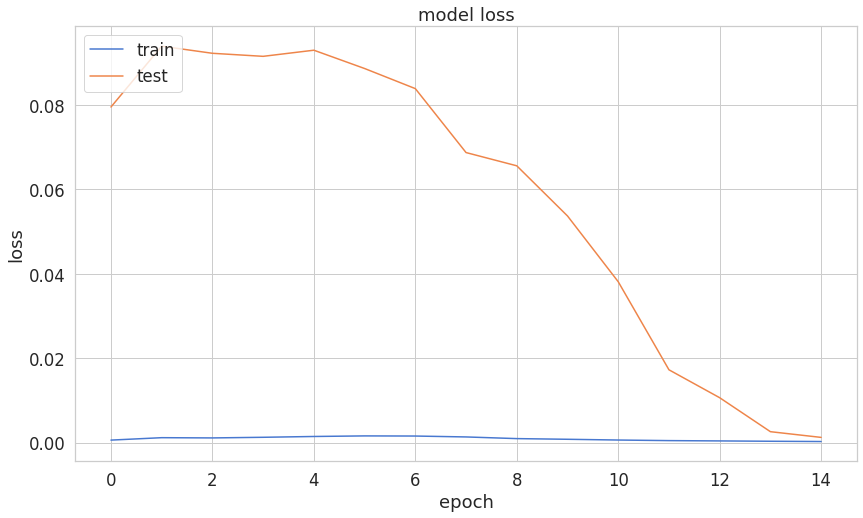

In [62]:
plt.plot(history_open.history['loss'])
plt.plot(history_open.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction

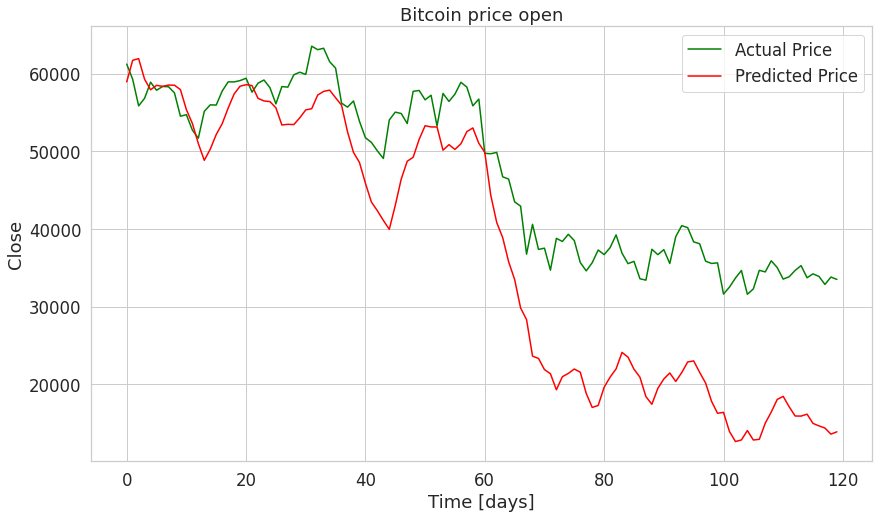

In [64]:
y_open_predict = model_open.predict(X_open_test)

y_open_test_inverse = open_scaler.inverse_transform(y_open_test)
y_open_predict_inverse = open_scaler.inverse_transform(y_open_predict)
 
plt.plot(y_open_test_inverse, label="Actual Price", color='green')
plt.plot(y_open_predict_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price open')
plt.xlabel('Time [days]')
plt.ylabel('Close')
plt.legend(loc='best')
 
plt.show();

# Delta changes open/close

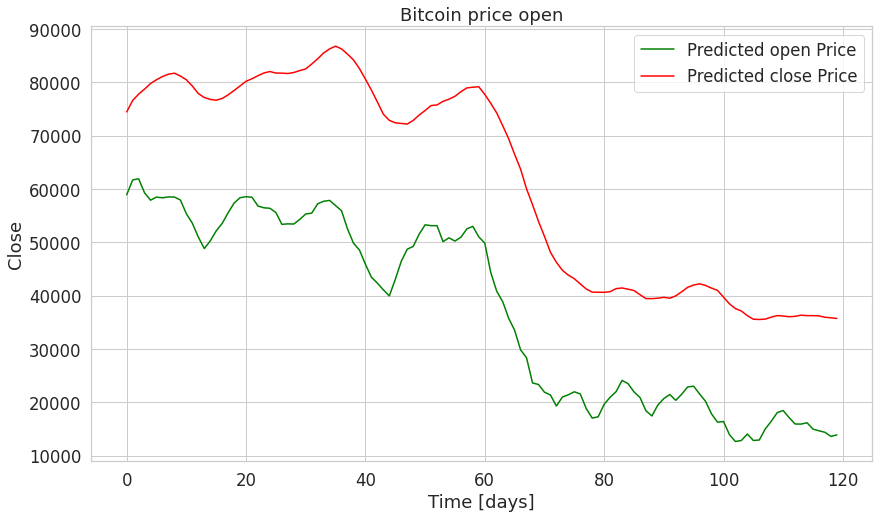

In [73]:
plt.plot(y_open_predict_inverse, label="Predicted open Price", color='green')
plt.plot(y_close_predict_inverse, label="Predicted close Price", color='red')
 
plt.title('Bitcoin price open')
plt.xlabel('Time [days]')
plt.ylabel('Close')
plt.legend(loc='best')
 
plt.show();

In [65]:
test_df = pd.DataFrame(y_close_predict_inverse)
test_df.rename(columns={0: 'y_close_pred'}, inplace=True)
test_df.head()

,y_close_pred
0,74468.765625
1,76609.414062
2,77801.765625
3,78748.156250
4,79795.671875


In [66]:
test_df['y_open_pred'] = y_open_predict_inverse
test_df['y_close'] = y_close_test_inverse
test_df['y_open'] = y_open_test_inverse
test_df.head()

,y_close_pred,y_open_pred,y_close,y_open
0,74468.765625,58931.160156,59302.316406,61221.132813
1,76609.414062,61707.292969,55907.199219,59267.429688
2,77801.765625,61922.152344,56804.902344,55840.785156
3,78748.156250,59263.578125,58870.894531,56825.828125
4,79795.671875,57910.269531,57858.921875,58893.078125


In [68]:
test_df['up_pred'] = test_df.apply(lambda row: row['y_close_pred'] - row['y_open_pred'] > 0, axis=1)
test_df['up'] = test_df.apply(lambda row: row['y_close'] - row['y_open'] > 0, axis=1)
test_df.head()

,y_close_pred,y_open_pred,y_close,y_open,up_pred,up
0,74468.765625,58931.160156,59302.316406,61221.132813,True,False
1,76609.414062,61707.292969,55907.199219,59267.429688,True,False
2,77801.765625,61922.152344,56804.902344,55840.785156,True,True
3,78748.156250,59263.578125,58870.894531,56825.828125,True,True
4,79795.671875,57910.269531,57858.921875,58893.078125,True,False


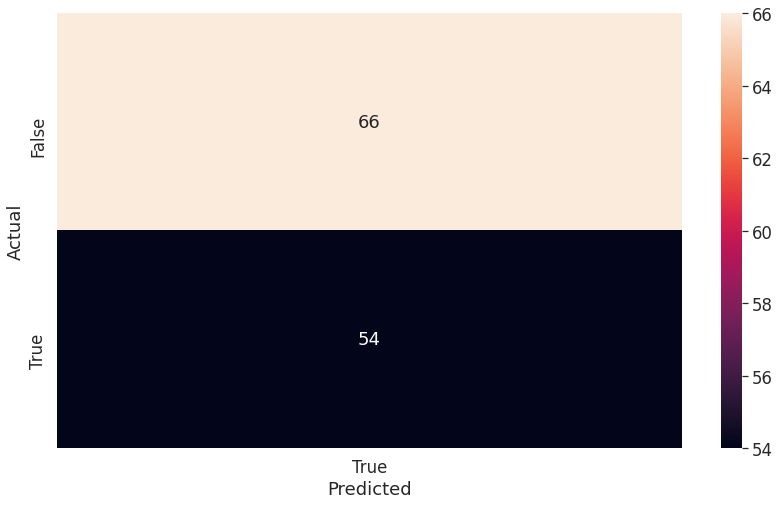

In [72]:
confusion_matrix = pd.crosstab(test_df['up'], test_df['up_pred'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()